In [13]:
import xnemogcm
import xgcm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from matplotlib.colors import LogNorm
import gsw
import cmocean.cm as cmo
import xarray as xr
import datetime
import cmasher as cmr
import matplotlib.colors as mcolors
xr.set_options(keep_attrs=True)
plt.rcParams['font.size']=14

In [2]:
n_lev=16
col = cmr.take_cmap_colors(cmo.thermal, n_lev, return_fmt='hex')

col[-1]='#faf0e6'
colors_halo=mcolors.LinearSegmentedColormap.from_list('colormap', col)
print(len(col))

16


# Compare to GLORYS12

In [3]:
# path to the stored data
path12=('../../MAUD_RISE_config/maud_v4/g12/')
# load Glorys12 fields , use compat override, since the time in the time dimension changes after 2018, but this data is not used anyways
dsha_g12=xr.open_mfdataset(path12+'[T,S,M]*_ha_g12.nc',compat='override')
dstc_g12=xr.open_mfdataset(path12+'[T,S,M]*_tc_g12.nc',compat='override')
time_arrayg12=np.array(dstc_g12.time_counter,dtype=np.datetime64)
#vectorg12=np.zeros(len(time_arrayg12))-70

In [4]:
dsha_g12['sig0_ha12']=gsw.sigma0(dsha_g12.vosaline,dsha_g12.votemper)
dstc_g12['sig0_tc12']=gsw.sigma0(dstc_g12.vosaline,dstc_g12.votemper)

# Maud36

In [5]:
# path to the stored data
path36=('../../MAUD_RISE_config/maud_v4/m36_ke2/rev_data/')

dsha36=xr.open_mfdataset(path36+'[T,S,M,N]*_ha*_m36.nc')
dsic36=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_ke2/si*_m36.nc')
del dsic36['sig0_l2']
dstc36=xr.open_mfdataset(path36+'[T,S,M,N]*_tc*_m36.nc')
# load domain for computing the depth
dep36=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_mask/1_domain_cfg_50levels_new.nc')
deptht=dep36.e3t_1d.cumsum(dim='z')- 0.5*dep36.e3t_1d.isel(z=0)
depthw=dep36.e3w_1d.cumsum(dim='z')- 0.5*dep36.e3w_1d.isel(z=0)
deptht=deptht.swap_dims({'z':'z_c'})
deptht=deptht.rename("deptht")
depthw=depthw.swap_dims({'z':'z_f'})
depthw=depthw.rename("depthw")
# load masks for averaging sea ice fields
mask=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_mask/mask*.nc')

In [6]:
sic_tc=dsic36.siconc.where(mask.mask_tc==1).mean(dim={'x_c','y_c'})
sic_ha=dsic36.siconc.where(mask.mask_ha_mod==1).mean(dim={'x_c','y_c'})
sic_tc.load()
sic_ha.load()

/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'siconc' (t: 4178)>
array([ 0.,  0.,  0., ..., nan, nan, nan], dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2007-01-01T12:00:00 ... 2018-06-11T12:00:00
Attributes:
    standard_name:       sea_ice_area_fraction
    long_name:           Sea-ice area fraction
    online_operation:    average
    interval_operation:  120 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 120 s)
    arakawa_point_type:  T
    coordinates:         nav_lat nav_lon

In [12]:
dsha36.coords['depth']=deptht
dstc36.coords['depth']=deptht
dsha36.coords['depthw']=depthw
dstc36.coords['depthw']=depthw
dsha36.coords['month']=dsha36.t.dt.month
dsha36.coords['year']=dsha36.t.dt.year
dsha36.coords['day']=dsha36.t.dt.day
time_array36=np.array(dsha36.t,dtype=np.datetime64)
# compute sigma0
dsha36['sig0_ha36']=gsw.sigma0(dsha36.S_mean_ha,dsha36.T_mean_ha)
dstc36['sig0_tc36']=gsw.sigma0(dstc36.S_mean_tc,dstc36.T_mean_tc)


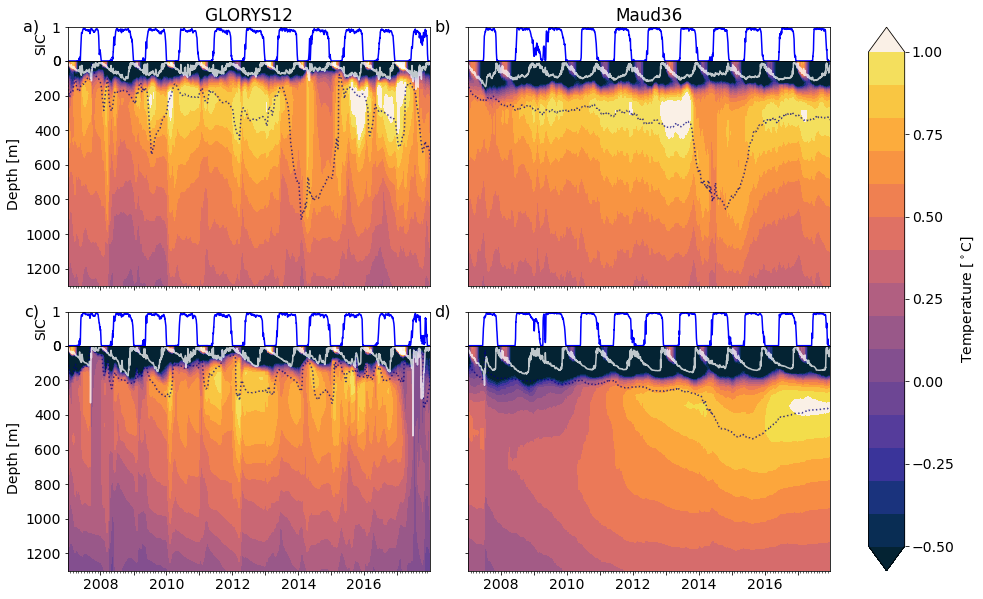

In [42]:
# Figure 6 of the manuscript
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec


fig = plt.figure(figsize=(15,10))
gs = GridSpec(2,3, width_ratios=[1,1,0.1],wspace=.15,hspace=.1)#,wspace=0.3)

gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0,0],hspace=0, height_ratios=[.15,1])
gs2 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,0],hspace=0, height_ratios=[.15,1])
gs3 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0,1],hspace=0, height_ratios=[.15,1])
gs4 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,1],hspace=0, height_ratios=[.15,1])


#ttc_g12 = fig.add_subplot(gs2[1])#,sharey=ttc_m12)
sha_g12 = fig.add_subplot(gs1[0],sharex=ttc_g12,xticklabels=[])
tha_g12 = fig.add_subplot(gs1[1],sharex=ttc_g12,xticklabels=[])
stc_g12 = fig.add_subplot(gs2[0],sharex=ttc_g12,xticklabels=[])
ttc_g12 = fig.add_subplot(gs2[1])#,sharey=ttc_m12)
#ttc_m36 = fig.add_subplot(gs4[1])#,sharey=ttc_g12)
sha_m36 = fig.add_subplot(gs3[0],sharex=ttc_m36,xticklabels=[])#,sharey=sha_g12)
tha_m36 = fig.add_subplot(gs3[1],sharex=ttc_m36,xticklabels=[])#,sharey=tha_g12)
stc_m36 = fig.add_subplot(gs4[0],sharex=ttc_m36,xticklabels=[])#,sharey=stc_g12)
ttc_m36 = fig.add_subplot(gs4[1])#,sharey=ttc_g12)

c_ax=fig.add_subplot(gs[:,2])


ax=sha_g12
dsha_g12.ileadfra.plot(x="time_counter",ax=ax,color='b')
ax.set_ylabel('SIC')
ax.set_xlabel('')
ax.set_title('') 
ax.set_ylim(0,1)
ax.set_xticklabels('')
plt.text(-0.1, 1, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=tha_g12
ct1=dsha_g12.votemper.plot.contourf(x='time_counter',y='deptht',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)
c1=dsha_g12.sig0_ha12.plot.contour(x='time_counter',y='deptht',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dsha_g12.somxl010.plot(x="time_counter",ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_title('') 

ax.set_xticks([datetime.datetime(i,1,1) for i in years])
ax.set_xticks(minor_ticks, minor=True);
ax.set_xticklabels('')

ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))


ax=stc_g12
dstc_g12.ileadfra.plot(x="time_counter",ax=ax,color='b')
ax.set_ylabel('SIC')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
ax.set_ylim(0,1)
plt.text(-0.1, 1, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=ttc_g12
dstc_g12.votemper.plot.contourf(x='time_counter',y='deptht',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=dstc_g12.sig0_tc12.plot.contour(x='time_counter',y='deptht',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dstc_g12.somxl010.plot(x="time_counter",ax=ax,color='w',alpha=.75)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')

ax.set_xticks([datetime.datetime(i,1,1) for i in years[1::2]])#
ax.set_xticklabels(years[1::2])
ax.set_xticks([datetime.datetime(i,1,1) for i in years])#,dsha36.year[year1st])
ax.set_xticks(minor_ticks, minor=True);

ax.set_title('') 
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)

# Maud36
ax=sha_m36
sic_ha.plot(x="t",ax=ax,color='b')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylim(0,1)
plt.text(-0.07, 1, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=tha_m36
ct1=dsha36.T_mean_ha.plot.contourf(x='t',y='depth',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)
c1=dsha36.sig0_ha36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dsha36.MLD_mean_ha.plot(x='t',ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 

ax.set_xticks([datetime.datetime(i,1,1) for i in years])#,dsha36.year[year1st])
ax.set_xticks(minor_ticks, minor=True);
ax.set_xticklabels('')

ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))

ax=stc_m36
sic_tc.plot(x="t",ax=ax,color='b')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.set_ylim(0,1)
plt.text(-0.07, 1, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=ttc_m36
dstc36.T_mean_tc.plot.contourf(x='t',y='depth',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=dstc36.sig0_tc36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dstc36.MLD_mean_tc.plot(x='t',ax=ax,color='w',alpha=.75)
ax.set_ylabel('')
ax.set_title('') 

ax.set_xticks([datetime.datetime(i,1,1) for i in years[1::2]])#
ax.set_xticklabels(years[1::2])
ax.set_xticks([datetime.datetime(i,1,1) for i in years])
ax.set_xticks(minor_ticks, minor=True);
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)

ax.set_xlabel('')
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))

sha_g12.set_title('GLORYS12')
sha_m36.set_title('Maud36')
plt.colorbar(ct1,cax=c_ax,orientation="vertical",label='Temperature [$^\circ$C]',ticks=np.arange(-.5,1.25,0.25))

plt.savefig('./T_sic_hatc_g12_m36.jpg',dpi=300)




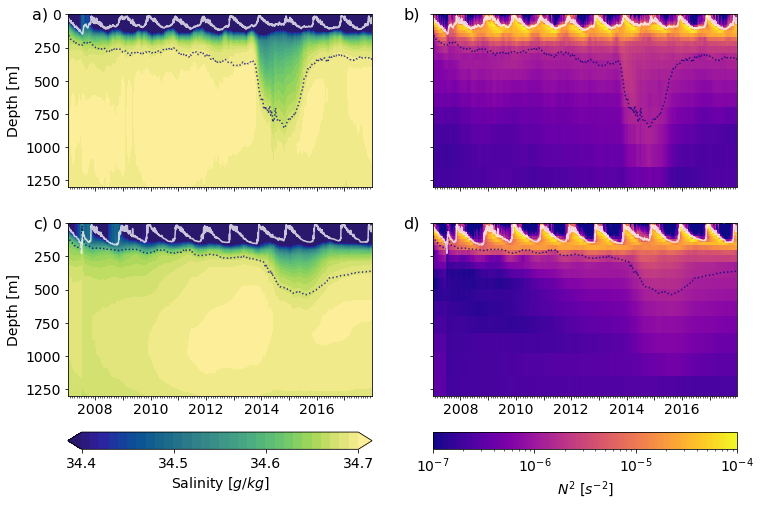

In [41]:
# Supplementary Figure A3

fig,axes=plt.subplots(3,2,figsize=(12,8),gridspec_kw={'height_ratios':[1,1,0.1],'hspace':.3})
ax=axes[0,0]
cs1=dsha36.S_mean_ha.plot.contourf(x='t',y='depth',ax=ax,cmap=cmo.haline,vmin=34.4,vmax=34.7,levels=31,add_colorbar=False)
c1=dsha36.sig0_ha36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dsha36.MLD_mean_ha.plot(x="t",ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticks([datetime.datetime(i,1,1) for i in years])
ax.set_xticks(minor_ticks, minor=True);
ax.set_xticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))
plt.text(-0.09, 1, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=axes[1,0]
dstc36.S_mean_tc.plot.contourf(x='t',y='depth',ax=ax,cmap=cmo.haline,vmin=34.4,vmax=34.7,levels=31,add_colorbar=False)#,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=dstc36.sig0_tc36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dstc36.MLD_mean_tc.plot(x="t",ax=ax,color='w',alpha=.75)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticks([datetime.datetime(i,1,1) for i in years[1::2]])#
ax.set_xticklabels(years[1::2])
ax.set_xticks([datetime.datetime(i,1,1) for i in years])
ax.set_xticks(minor_ticks, minor=True);
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))
plt.colorbar(cs1,cax=axes[2,0],orientation="horizontal",label='Salinity [$g/kg$]',ticks=np.arange(34.4,34.8,0.1))
plt.text(-0.09, 1, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')


ax=axes[0,1]
cn1=dsha36.N2_mean_ha.plot.pcolormesh(x='t',y='depthw',ax=ax,norm=LogNorm(vmin=1e-7,vmax=1e-4),cmap='plasma',add_colorbar=False)
c1=dsha36.sig0_ha36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dsha36.MLD_mean_ha.plot(x="t",ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
ax.set_xticks([datetime.datetime(i,1,1) for i in years])
ax.set_xticks(minor_ticks, minor=True);
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))
plt.text(-0.07, 1, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')

ax=axes[1,1]
dstc36.N2_mean_tc.plot.pcolormesh(x='t',y='depthw',ax=ax,norm=LogNorm(vmin=1e-7,vmax=1e-4),cmap='plasma',add_colorbar=False)#,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=dstc36.sig0_tc36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dstc36.MLD_mean_tc.plot(x="t",ax=ax,color='w',alpha=.75)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticks([datetime.datetime(i,1,1) for i in years[1::2]])#
ax.set_xticklabels(years[1::2])
ax.set_xticks([datetime.datetime(i,1,1) for i in years])
ax.set_xticks(minor_ticks, minor=True);
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))
plt.colorbar(cn1,cax=axes[2,1],orientation="horizontal",label='$N^2$ [$s^{-2}$]')#,ticks=np.arange(34.4,34.9,0.1))
plt.text(-0.07, 1, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
plt.savefig('./S_N2_tc_ha_m36.jpg',dpi=300)